In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import csv
import os
import time

%matplotlib inline 

import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## Data Retrieval

In [3]:
if not os.path.isdir('./player_data'):
    
    os.makedirs('./player_data', exist_ok=True)

    # Iterate through seasons.
    for i in range (1946, 2020):

        #no data for these years
        if i not in [1946, 1947, 1948, 1949, 1950]:
            continue

        time.sleep(3)

        # Get URL
        url_year_part = str(i) + '-' + str(i + 1)[-2:]
        url = 'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season=' + url_year_part + '&SeasonType=Regular+Season&StatCategory=MIN'

        headers = {
            'referrer': 'https://google.com',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Connection': 'keep-alive',
            'DNT': '1',
            'Host': 'stats.nba.com',
            'Referer': 'https://stats.nba.com/leaders/?Season=1950-51&SeasonType=Regular%20Season&StatCategory=MIN',
            'Sec-Fetch-Dest': 'empty',
            'Sec-Fetch-Mode': 'cors',
            'Sec-Fetch-Site': 'same-origin',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
            'x-nba-stats-origin': 'stats',
            'x-nba-stats-token': 'true',
            'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw=='
            }

        req = requests.get(url, headers=headers)
        print(url)

        stat_dict = json.loads(req.content)
        csv_path = 'player_data/' + url_year_part + '.csv'
        csv_columns = stat_dict['resultSet']['headers']
        with open(csv_path, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(csv_columns)
            for row in stat_dict['resultSet']['rowSet']:
                writer.writerow(row)


## Clustering Runs

Working on 2019...


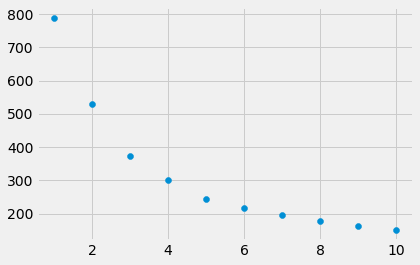

In [26]:
years = [x for x in os.listdir(path='./player_data') if x[-4:] == '.csv']
years.sort()

# initializing K-Means Results list, with header row
results = ['year', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']

# initializing player statistics
player_data = [['year', 'player', 'GP', 'MIN', 'PTS', 'REB', 'AST',
               'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']]

# initializing centroid statistics
centroid_data = [['year', 'n_clusters', 'cluster', 'PTS', 'REB', 'AST']]

# year by year
#for year in range(1973, 2020):
#for year in range(1951, 2020):
for year in range(2019, 2020):    
    
    print('Working on {}...'.format(year))
    
    df = pd.read_csv('./player_data/' + str(year) + '-' + str(year + 1)[-2:] + '.csv')
    
    cols = ['PLAYER', 'GP', 'MIN']
    k_means_attributes = ['PTS', 'REB', 'AST']
    cols.extend(k_means_attributes)
    
    # Per 36 stats for K-Means attributes
    # Steals, Blocks start in 1973
    per_36 = df.loc[:,cols]
    for attrib in k_means_attributes:
        per_36.loc[:, attrib] = (per_36[attrib] * (36 / per_36['MIN'])).round(1)
    
    # Grabbing per_36 dataframe to start building player file
    per_36.insert(0, 'year', year)
    curr_player_data = per_36.to_numpy()
    
    # Checking relationships between pts, reb, ast
    #sns.pairplot(per_36[k_means_attributes])
    
    # Scaling
    scaler = preprocessing.StandardScaler()
    per_36_scaled = scaler.fit_transform(per_36[k_means_attributes])
        
    clusters = list(range(1, 11))
#    clusters = [3, 5]
    inertias = []
    silhouettes = []
    avg_dist_from_centroids = []
    
    for k in clusters:
        
        kmeans = cluster.KMeans(n_clusters=k)
        kmeans.fit(per_36_scaled)
        
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        inertia = kmeans.inertia_
        #silhouette_score = metrics.silhouette_score(per_36_scaled, labels, metric='euclidean')
        
        # Equalizes inertia metric across different numbers of players in league 
        avg_dist_from_centroid = inertia/len(per_36_scaled)
        
        inertias.append(round(inertia, 1))
        #silhouettes.append(round(silhouette_score, 1))
        avg_dist_from_centroids.append(avg_dist_from_centroid)
            
        # Logs unnormalized PTS/REB/AST values for each centroid, so we have frames of reference 
        # for the clusters each player ends up in
        centroid_avgs = pd.DataFrame(data=scaler.inverse_transform(centroids),
                                    columns=k_means_attributes)
        centroid_avgs.insert(0, column='label', value=centroid_avgs.index)
        centroid_avgs.insert(0, column='n_clusters', value=k)
        centroid_avgs.insert(0, column='year', value=year)
        centroid_data.extend(centroid_avgs.to_numpy().tolist())
            
        curr_player_data = np.hstack((curr_player_data, labels.reshape(-1, 1)))

        
    plt.scatter(clusters, inertias)
    #plt.scatter(clusters, silhouettes)
    
    avg_dist_from_centroids.insert(0, year)
    results.append(avg_dist_from_centroids)
    
    player_data.extend(curr_player_data.tolist())

# results to CSV
csv_path = 'k_means_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for year in results:
        writer.writerow(year)
        
csv_path = 'player_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for player_year in player_data:
        writer.writerow(player_year)
        
csv_path = 'centroid_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for centroid in centroid_data:
        writer.writerow(centroid)

## Points of Interest

In [5]:
df = pd.read_csv('k_means_results.csv')
df.head()
print(df)

    year  one       two     three      four      five       six     seven  \
0   1951  3.0  1.848493  1.471374  1.174746  0.999033  0.868638  0.754586   
1   1952  3.0  1.972629  1.492516  1.142033  0.901915  0.778178  0.703585   
2   1953  3.0  1.810020  1.239339  0.952105  0.774378  0.660931  0.592296   
3   1954  3.0  1.783581  1.226210  0.897055  0.732998  0.625207  0.552261   
4   1955  3.0  1.731446  1.239021  1.001555  0.883439  0.762508  0.690187   
..   ...  ...       ...       ...       ...       ...       ...       ...   
64  2015  3.0  2.040784  1.425808  1.172330  0.993417  0.866313  0.759737   
65  2016  3.0  2.094387  1.486038  1.155783  0.998039  0.857921  0.773742   
66  2017  3.0  2.098790  1.494345  1.238152  1.031028  0.882899  0.808984   
67  2018  3.0  2.085481  1.454910  1.177867  0.997479  0.866173  0.793677   
68  2019  3.0  2.016259  1.424446  1.147343  0.927602  0.821133  0.734791   

       eight      nine       ten  
0   0.630307  0.551954  0.475341  
1   0

### Cluster grouping over time

Hopefully, we'll see our metric get closer to zero year over year for our three-cluster K-means runs, meaning that three clusters (point-wing-big) describes the data better over time.

And hopefully, it will get further from zero for our five-cluster K-means runs, as the point-shooting guard-small forward-power forward-center groupings fall out of fashion.

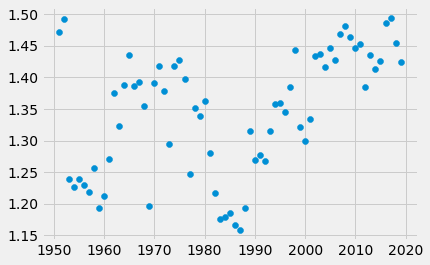

In [6]:
plt.scatter(x=df['year'], y=df['three'])

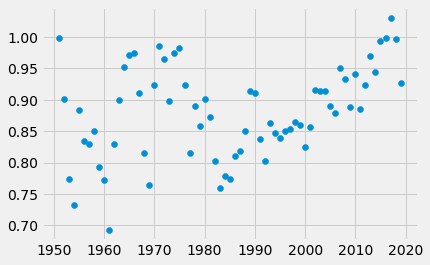

In [7]:
plt.scatter(x=df['year'], y=df['five'])

Nope. Cluster fit was scattered through the 70s, then hit a low point in the mid 80s, and has gradually increased in the time since.